# Benchmarking LaVague on Mind2Web

We will be benchmarking LaVague on Mind2Web, a dataset for agents.

In [1]:
from lavague.defaults import default_get_driver
import inspect

get_driver = default_get_driver
driver = get_driver()
    
# Gets the original source code of the get_driver method
source_code = inspect.getsource(get_driver)

# Split the source code into lines and remove the first line (method definition)
source_code_lines = source_code.splitlines()[1:]
source_code_lines = [line.strip() for line in source_code_lines[:-1]]
import_lines = [line for line in source_code_lines if line.startswith("from") or line.startswith("import")] 
exec("\n".join(import_lines))

/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will use a GPT-3.5 from Azure OpenAI

In [2]:
import os
from llama_index.llms.azure_openai import AzureOpenAI
from lavague.prompts import DEFAULT_PROMPT

api_key=os.getenv("AZURE_OPENAI_KEY")
api_version="2024-02-15-preview"
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
model = "gpt-35-turbo"
deployment_name = "gpt-35-turbo"

class LLM(AzureOpenAI):
    def __init__(self):
        super().__init__(
            model=deployment_name,
            deployment_name=deployment_name,
            api_key=api_key,
            azure_endpoint=azure_endpoint,
            api_version=api_version,
            temperature=0.0
        )
llm = LLM()

## Load dataset

In [3]:
import pandas as pd 
from datasets import load_dataset

dataset = load_dataset("BigAction/mind2web_clean")

df = dataset["train"].to_pandas()
df.head(5)

Unnamed: 0        split                        annotation_uid  \
0        6033    test_task  640e0425-bceb-45ff-ba4d-dbc5b62e31d5   
1        3394  test_domain  34e0bf85-6441-40cb-b7f6-d107e5bcb049   
2         320  test_domain  77269ea5-70a4-4cfa-a2f9-9937a1c55096   
3        6669    test_task  7f90a191-9dbe-478a-8ae2-8aa45b790158   
4         226  test_domain  332ed50d-4772-4eb3-9de9-27ff39abc161   

                                      confirmed_task  \
0              Find the "Rock And Roll Over" reviews   
1         Look up the visitors trend for Apple stock   
2  Search for early care and education programs f...   
3        Find more films from the director of Smile.   
4                            Create a Fitness board.   

                                            raw_html  \
0  <!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.0 Tr...   
1  <!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.0 Tr...   
2  <!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.0 Tr...   
3  <!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.0 Tr...   
4  <!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.0 Tr...   

                                        cleaned_html  \
0  <html backend_node_id="338">\n  <body>\n    <d...   
1  <html backend_node_id="14307">\n  <div backend...   
2  <html backend_node_id="44287">\n  <body>\n    ...   
3  <html backend_node_id="23177">\n  <body>\n    ...   
4  <html backend_node_id="123">\n  <body backend_...   

                             action_uid  \
0  96238fb3-bc46-4dff-95c0-4b2d4ecc70ea   
1  8043e8e8-bb7a-4521-80bf-246bc16e883c   
2  b416d08b-90c4-43e1-b3d6-9d4a05e56a06   
3  fd713700-3876-44a8-80ab-4da898beab42   
4  01342a5e-5cc3-45e7-bd9d-b522611fc7bf   

                                           operation  \
0  {'op': 'TYPE', 'original_op': 'TYPE', 'value':...   
1  {'op': 'CLICK', 'original_op': 'CLICK', 'value...   
2  {'op': 'CLICK', 'original_op': 'CLICK', 'value...   
3  {'op': 'CLICK', 'original_op': 'CLICK', 'value...   
4  {'op': 'CLICK', 'original_op': 'CLICK', 'value...   

                                                code  \
0  ```python\nelement = driver.find_element(By.XP...   
1  ```python\nelement = driver.find_element(By.XP...   
2  ```python\nelement = driver.find_element(By.XP...   
3  ```python\nelement = driver.find_element(By.XP...   
4  ```python\nelement = driver.find_element(By.XP...   

                                    cur_actions_desc  \
0  Enter "Rock And Roll Over" in the text box to ...   
1  Click on "AAPL" to look up the visitors trend ...   
2             Select the After School Care checkbox.   
3                                  Click on "Smile."   
4              Click on James Smith's profile image.   

                                   cur_actions_reprs  \
0  [textbox]  Enter artist name or song title -> ...   
1                               [div]  AAPL -> CLICK   
2             [checkbox]  After School Care -> CLICK   
3                              [div]  Smile -> CLICK   
4                        [img]  James Smith -> CLICK   

                                      pos_candidates  \
0  [{'attributes': '{"backend_node_id": "248", "b...   
1  [{'attributes': '{"backend_node_id": "14603", ...   
2  [{'attributes': '{"backend_node_id": "44285", ...   
3  [{'attributes': '{"backend_node_id": "23642", ...   
4  [{'attributes': '{"backend_node_id": "117", "b...   

                                   prev_actions_desc  \
0                                               None   
1  ['Enter "apple" in the search box to look up t...   
2  ['Click on the "services for RESIDENTS" link.'...   
3  ['Search for "Smile" in the TV Shows and Movie...   
4                                               None   

                                  prev_actions_reprs  
0                                               None  
1  ['[textbox]  Search for news, symbols or compa...  
2  ['[link]  services for RESIDENTS -> CLICK', '[...  
3  ['[textbox]  Search TV Shows and Movies... -> ...  
4                          

# Utils

We will define some utility functions for this benchmark.



In [4]:
import re
import ast

def keep_assignments(code_snippet):
    # Regex to match variable assignments. This pattern assumes variable names are valid Python identifiers
    # and captures typical assignment statements, excluding those that might appear in comments or strings.
    pattern = r'^\s*[a-zA-Z_][a-zA-Z0-9_]*\s*=\s*.+'

    # Filter and keep only lines with variable assignments
    assignments = [line for line in code_snippet.split('\n') if re.match(pattern, line)]

    # Join the filtered lines back into a string
    return "\n".join(assignments)

# This function will be used to visit each node in the AST
class VariableVisitor(ast.NodeVisitor):
    def __init__(self):
        super().__init__()
        self.output = []
    
    def visit_Assign(self, node):
        
        # For each assignment, print the targets (variables)
        for target in node.targets:
            if isinstance(target, ast.Name):  # Ensure it's a variable assignment
                self.output.append(target.id)

In [5]:
from bs4 import BeautifulSoup

def beautify_html(html_string):
    # Use BeautifulSoup to prettify the HTML
    soup = BeautifulSoup(html_string, 'html.parser')
    pretty_html_string = soup.prettify()
    return pretty_html_string

# Function to extract all 'backend_node_id' attributes
def extract_backend_node_ids(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    return set([tag['backend_node_id'] for tag in soup.find_all(attrs={"backend_node_id": True})])

def intersection_score(set1, set2):
    intersection_set = set1 & set2
    intersection_len = len(intersection_set)
    ratio1 = intersection_len / len(set1)
    ratio2 = intersection_len / len(set2) 
    return max(ratio1, ratio2), min(ratio1, ratio2)

def intersection_backend_node_id(ground_truth_outer_html, context_str):
    ground_truth_ids = extract_backend_node_ids(ground_truth_outer_html)
    context_ids = extract_backend_node_ids(context_str)
    recall, precision = intersection_score(ground_truth_ids, context_ids)
    return recall, precision

def load_html(html, driver):
    """Loads a specific HTML content into the browser."""
    file_path = 'sample_page.html'

    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(html)
        
    abs_file_path = os.path.abspath("sample_page.html")

    # Use the file:/// protocol to load the local HTML file
    driver.get(f"file:///{abs_file_path}")

In [6]:

from langchain_text_splitters import RecursiveCharacterTextSplitter
from llama_index.core.node_parser import LangchainNodeParser, CodeSplitter
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core import VectorStoreIndex, Document
from lavague.defaults import DefaultEmbedder

def get_retriever_recursive(embed, html):
    
    K = 3
    
    text_list = [html]
    documents = [Document(text=t) for t in text_list]
    
    splitter = LangchainNodeParser(lc_splitter=RecursiveCharacterTextSplitter.from_language(
        language="html",
    ))
    
    nodes = splitter.get_nodes_from_documents(documents)
    nodes = [node for node in nodes if node.text]

    index = VectorStoreIndex(nodes, embed_model=embed)
    retriever_recursive = BM25Retriever.from_defaults(index = index, similarity_top_k=K)
    return retriever_recursive

def get_retriever_code(embed, html):
    
    K = 3
    
    text_list = [html]
    documents = [Document(text=t) for t in text_list]
    
    splitter = CodeSplitter(
        language="html",
        chunk_lines=50,  # lines per chunk
        chunk_lines_overlap=15,  # lines overlap between chunks
        max_chars=2000,  # max chars per chunk
    )
    
    nodes = splitter.get_nodes_from_documents(documents)
    nodes = [node for node in nodes if node.text]

    index = VectorStoreIndex(nodes, embed_model=embed)
    retriever_code = BM25Retriever.from_defaults(index = index, similarity_top_k=K)
    return retriever_code

def get_nodes(query, html, get_retriever, embedder):    
    retriever = get_retriever(embedder, html)
    source_nodes = retriever.retrieve(query)
    source_nodes = [node.text for node in source_nodes]
    return source_nodes

embedder = DefaultEmbedder()

import re

def extract_first_python_code(markdown_text: str):
    # Pattern to match the first ```python ``` code block
    pattern = r"```python(.*?)```"

    # Using re.DOTALL to make '.' match also newlines
    match = re.search(pattern, markdown_text, re.DOTALL)
    if match:
        # Return the first matched group, which is the code inside the ```python ```
        return match.group(1).strip()
    else:
        # Return None if no match is found
        return None

decontaminate_html = lambda x: re.sub(r' backend_node_id="\d+"', '', x)

config.json: 100%|██████████| 743/743 [00:00<00:00, 4.57MB/s]
model.safetensors: 100%|██████████| 133M/133M [00:00<00:00, 494MB/s] 
tokenizer_config.json: 100%|██████████| 366/366 [00:00<00:00, 2.34MB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 41.4MB/s]
tokenizer.json: 100%|██████████| 711k/711k [00:00<00:00, 35.5MB/s]
special_tokens_map.json: 100%|██████████| 125/125 [00:00<00:00, 871kB/s]


In [47]:
from tqdm import tqdm

outputs = []

get_retriever = get_retriever_recursive
retriever_name = get_retriever.__name__

for index, row in tqdm(df.iterrows()):
    
    if row["action_uid"] in results["action_uid"].values:
        continue
    
    ground_truth_code = row["code"]
    html = row["cleaned_html"]
    query = row["cur_actions_desc"]
    action_uid = row["action_uid"]

    backend_node_id = ground_truth_code.split("backend_node_id")[1].split("']")[0].replace("='","")

    load_html(html, driver)

    source_nodes = get_nodes(query, html, get_retriever, embedder)
    backend_node_id = ground_truth_code.split("backend_node_id")[1].split("']")[0].replace("='","")

    ground_truth_element = driver.find_element(By.XPATH, f'//*[@backend_node_id="{backend_node_id}"]')
    ground_truth_outer_html = driver.execute_script("return arguments[0].outerHTML;", ground_truth_element)
    
    context_str = "\n".join(source_nodes)
    recall_retriever, precision_retriever = intersection_backend_node_id(ground_truth_outer_html, context_str)
    
    # We remove the backend node ids to ensure the LLM does not use them
    decontaminated_context_str = decontaminate_html(context_str)
    prompt = DEFAULT_PROMPT.format(context_str=decontaminated_context_str, query_str=query)

    response = llm.complete(prompt).text

    generated_code = extract_first_python_code(response)

    # Keep only the variable assignments in the generated code
    code = keep_assignments(generated_code)

    # Split the code into lines and keep only the first assignment
    code = code.split("\n")[0]
    parsed_code = ast.parse(code)

    recall_llm, precision_llm = None, None
    execution_error = ""

    try:
    # Create a visitor instance and use it to visit the nodes in the parsed AST
        visitor = VariableVisitor()
        visitor.visit(parsed_code)
        variable_name = visitor.output[0]

        # Execute the code to define the first variable
        exec(code)

        # Assign the variable to the target_element variable which will be used afterwards to compute score
        target_element = None
        exec(f"""target_element = {variable_name}""")

        target_outer_html = driver.execute_script("return arguments[0].outerHTML;", target_element)
        recall_llm, precision_llm = intersection_backend_node_id(ground_truth_outer_html, target_outer_html)
    except Exception as e:
        target_outer_html = ""
        execution_error = str(e)

    output = {
        "query": query,
        "recall_retriever": recall_retriever,
        "precision_retriever": precision_retriever,
        "recall_llm": recall_llm,
        "precision_llm": precision_llm,
        "html": html,
        "action_uid": action_uid,
        "source_nodes": ("-"*10).join(source_nodes),
        "ground_truth_code": f"""ground_truth_element = driver.find_element(By.XPATH, f'//*[@backend_node_id="{backend_node_id}"]')""",
        "ground_truth_outer_html": ground_truth_outer_html,
        "generated_code": generated_code,
        "target_outer_html": target_outer_html,
        "execution_error": execution_error,
        "retriever": retriever_name,
        "model": model,
    }
    outputs.append(output)
    
    results = pd.DataFrame(outputs)

    results.to_csv(f"benchmark_retriever_{retriever_name}_model_{model}.csv", index=False)

192it [06:13,  1.94s/it]


AttributeError: 'NoneType' object has no attribute 'split'

In [7]:
results = pd.read_csv("benchmark_retriever_get_retriever_recursive_model_gpt-35-turbo.csv")

In [8]:
results.head()

query  recall_retriever  \
0  Enter "Rock And Roll Over" in the text box to ...               0.0   
1  Click on "AAPL" to look up the visitors trend ...               1.0   
2             Select the After School Care checkbox.               1.0   
3                                  Click on "Smile."               1.0   
4              Click on James Smith's profile image.               1.0   

   precision_retriever  recall_llm  precision_llm  \
0             0.000000         0.0       0.000000   
1             0.114943         1.0       0.100000   
2             0.008772         1.0       1.000000   
3             0.050000         1.0       0.333333   
4             0.011236         1.0       1.000000   

                                                html  \
0  <html backend_node_id="338">\n  <body>\n    <d...   
1  <html backend_node_id="14307">\n  <div backend...   
2  <html backend_node_id="44287">\n  <body>\n    ...   
3  <html backend_node_id="23177">\n  <body>\n    ...   
4  <html backend_node_id="123">\n  <body backend_...   

                             action_uid  \
0  96238fb3-bc46-4dff-95c0-4b2d4ecc70ea   
1  8043e8e8-bb7a-4521-80bf-246bc16e883c   
2  b416d08b-90c4-43e1-b3d6-9d4a05e56a06   
3  fd713700-3876-44a8-80ab-4da898beab42   
4  01342a5e-5cc3-45e7-bd9d-b522611fc7bf   

                                        source_nodes  \
0  <div backend_node_id="2662">\n                ...   
1  <div backend_node_id="14708">\n               ...   
2  <span backend_node_id="44871">\n              ...   
3  <div backend_node_id="23101">\n               ...   
4  <body backend_node_id="187">\n    <div backend...   

                                   ground_truth_code  \
0  driver.find_element(By.XPATH, f'//*[@backend_n...   
1  driver.find_element(By.XPATH, f'//*[@backend_n...   
2  driver.find_element(By.XPATH, f'//*[@backend_n...   
3  driver.find_element(By.XPATH, f'//*[@backend_n...   
4  driver.find_element(By.XPATH, f'//*[@backend_n...   

                             ground_truth_outer_html  \
0  <input backend_node_id="248" type="text" name=...   
1  <li backend_node_id="14603" role="option" titl...   
2  <input backend_node_id="44285" type="checkbox"...   
3  <li backend_node_id="23642" role="option">\n  ...   
4      <img backend_node_id="117" alt="James Smith">   

                                      generated_code  \
0  # Let's proceed step by step.\n# First we need...   
1  # Let's proceed step by step.\n# First we need...   
2  # Let's proceed step by step.\n# First we need...   
3  # Let's proceed step by step.\n# First we need...   
4  # Let's proceed step by step.\n# First we need...   

                                   target_outer_html execution_error  \
0  <text backend_node_id="2663">Hi ! I have a Iba...             NaN   
1          <text backend_node_id="14606">AAPL</text>             NaN   
2  <input backend_node_id="44285" type="checkbox"...             NaN   
3         <text backend_node_id="23648">Smile</text>             NaN   
4      <img backend_node_id="117" alt="James Smith">             NaN   

                 retriever  model  
0  get_retriever_recursive    NaN  
1  get_retriever_recursive    NaN  
2  get_retriever_recursive    NaN  
3  get_retriever_recursive    NaN  
4  get_retriever_recursive    NaN

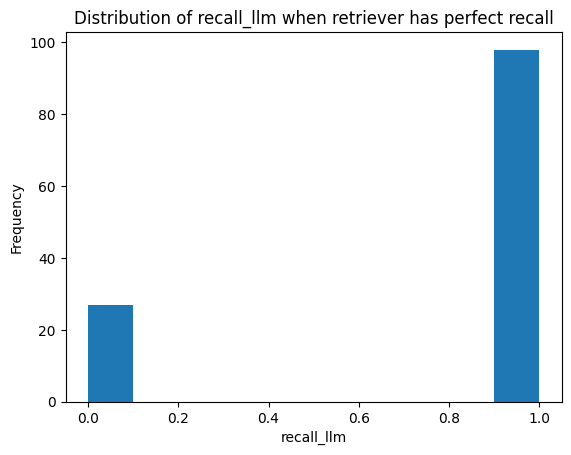

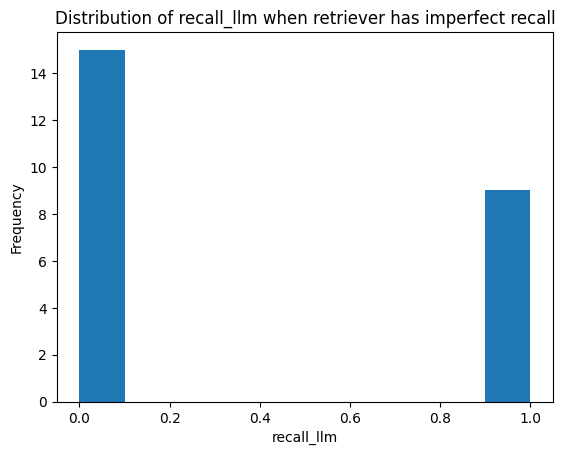

In [13]:
import matplotlib.pyplot as plt

x = results['recall_retriever']
y = results['recall_llm']

import matplotlib.pyplot as plt

# Filter results on recall retriever == 1.0
filtered_results = results[results['recall_retriever'] == 1.0]

# Plot distribution of recall_llm
plt.hist(filtered_results['recall_llm'], bins=10)
plt.xlabel('recall_llm')
plt.ylabel('Frequency')
plt.title('Distribution of recall_llm when retriever has perfect recall')
plt.show()

filtered_results = results[results['recall_retriever'] < 1.0]

# Plot distribution of recall_llm
plt.hist(filtered_results['recall_llm'], bins=10)
plt.xlabel('recall_llm')
plt.ylabel('Frequency')
plt.title('Distribution of recall_llm when retriever has imperfect recall')
plt.show()


In [96]:
print("Retriever performance: ", (results.recall_retriever == 1.0).mean())
print("LLM performance: ", (results.recall_llm == 1.0).mean())
print("Deperdition rate: ", (results.recall_llm == 1.0).mean() / (results.recall_retriever == 1.0).mean())

Retriever performance:  0.8177083333333334
LLM performance:  0.5572916666666666
Deperdition rate:  0.6815286624203821


In [105]:
perfect_retriever = results.loc[results.recall_retriever == 1.0]
(perfect_retriever.recall_llm == 1.0).mean()
# perfect_retriever = perfect_retriever.loc[~perfect_retriever.recall_llm.isna()]

0.6242038216560509

In [108]:
results

query  recall_retriever  \
0    Enter "Rock And Roll Over" in the text box to ...          0.000000   
1    Click on "AAPL" to look up the visitors trend ...          1.000000   
2               Select the After School Care checkbox.          1.000000   
3                                    Click on "Smile."          1.000000   
4                Click on James Smith's profile image.          1.000000   
..                                                 ...               ...   
187  Click on the search option to get the best rat...          0.000000   
188  Click on the "Benefits and financial support f...          1.000000   
189          Click on the link labeled "Thrill Rides."          0.000000   
190   Enter "Ohio" in the search box for the location.          1.000000   
191                      Click on the "Price" heading.          0.916667   

     precision_retriever  recall_llm  precision_llm  \
0               0.000000         0.0       0.000000   
1               0.114943         1.0       0.100000   
2               0.008772         1.0       1.000000   
3               0.050000         1.0       0.333333   
4               0.011236         1.0       1.000000   
..                   ...         ...            ...   
187             0.000000         0.0       0.000000   
188             0.016260         1.0       0.500000   
189             0.000000         0.0       0.000000   
190             0.012346         1.0       1.000000   
191             0.277311         1.0       0.055556   

                                                  html  \
0    <html backend_node_id="338">\n  <body>\n    <d...   
1    <html backend_node_id="14307">\n  <div backend...   
2    <html backend_node_id="44287">\n  <body>\n    ...   
3    <html backend_node_id="23177">\n  <body>\n    ...   
4    <html backend_node_id="123">\n  <body backend_...   
..                                                 ...   
187  <html backend_node_id="15457">\n  <body backen...   
188  <html backend_node_id="4953">\n  <body>\n    <...   
189  <html backend_node_id="64176">\n  <body backen...   
190  <html backend_node_id="1531">\n  <body>\n    <...   
191  <html backend_node_id="329709">\n  <body backe...   

                               action_uid  \
0    96238fb3-bc46-4dff-95c0-4b2d4ecc70ea   
1    8043e8e8-bb7a-4521-80bf-246bc16e883c   
2    b416d08b-90c4-43e1-b3d6-9d4a05e56a06   
3    fd713700-3876-44a8-80ab-4da898beab42   
4    01342a5e-5cc3-45e7-bd9d-b522611fc7bf   
..                                    ...   
187  5036b341-d933-4f21-9bde-af116b2f78e2   
188  bf65fe94-df6e-4817-8530-93bf6b9800a3   
189  c7cd25d6-0721-488d-9a01-975f6b1bc76d   
190  370ca9f4-e6ee-4576-bcf1-ea418704debf   
191  3bb445bc-1794-4365-8d2e-7eaea29db4e3   

                                          source_nodes  \
0    <div backend_node_id="2662">\n                ...   
1    <div backend_node_id="14708">\n               ...   
2    <span backend_node_id="44871">\n              ...   
3    <div backend_node_id="23101">\n               ...   
4    <body backend_node_id="187">\n    <div backend...   
..                                                 ...   
187  <div backend_node_id="16067">\n               ...   
188  <div backend_node_id="5365">\n              <f...   
189  <p backend_node_id="67582">\n                 ...   
190  <div backend_node_id="1948">\n                ...   
191  <div backend_node_id="344655">\n              ...   

                                     ground_truth_code  \
0    driver.find_element(By.XPATH, f'//*[@backend_n...   
1    driver.find_element(By.XPATH, f'//*[@backend_n...   
2    driver.find_element(By.XPATH, f'//*[@backend_n...   
3    driver.find_element(By.XPATH, f'//*[@backend_n...   
4    driver.find_element(By.XPATH, f'//*[@backend_n...   
..                                                 ...   
187  driver.find_element(By.XPATH, f'//*[@backend_n...   
188  driver.find_element(By.XPATH, f'//*[@backend_n...   
189  driver.find_e

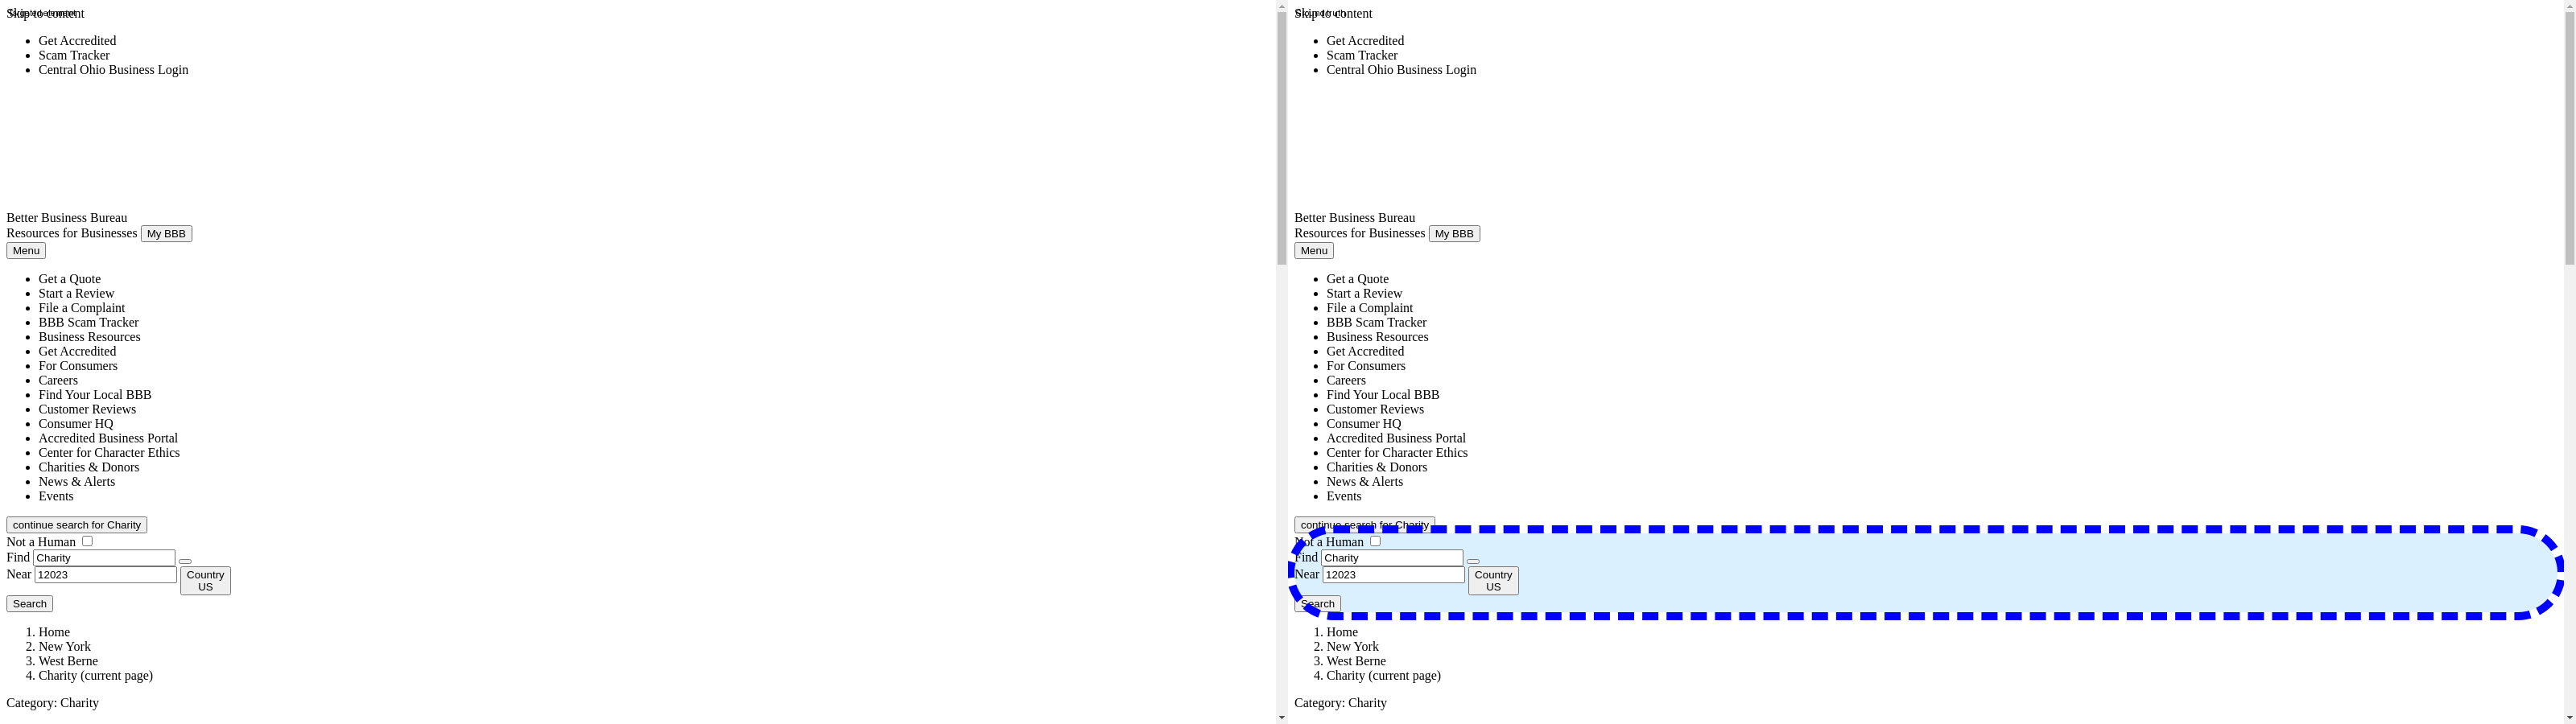

In [110]:
row = results.iloc[187]

html = row["html"]
load_html(html, driver)

ground_truth_code = row["ground_truth_code"]
exec(f"ground_truth_element = {ground_truth_code}")
generated_code = row["generated_code"]

code = keep_assignments(generated_code)

# Split the code into lines and keep only the first assignment
code = code.split("\n")[0]
parsed_code = ast.parse(code)

# Create a visitor instance and use it to visit the nodes in the parsed AST
visitor = VariableVisitor()
visitor.visit(parsed_code)
variable_name = visitor.output[0]

# Execute the code to define the first variable
exec(code)

# Assign the variable to the target_element variable which will be used afterwards to compute score
target_element = None
exec(f"""target_element = {variable_name}""")

def highlight_element(element, driver):
    driver.execute_script("""
    arguments[0].style.outline = "10px dashed blue";
    arguments[0].style.backgroundColor = "rgba(135, 206, 250, 0.3)";
    arguments[0].style.borderRadius = "50px";""", element)
    
def unhighlight_element(element, driver):
    driver.execute_script("""
    arguments[0].style.outline = "";
    arguments[0].style.backgroundColor = "";
    arguments[0].style.borderRadius = "";""", element)

highlight_element(ground_truth_element, driver)
driver.save_screenshot("screenshot1.png")
unhighlight_element(ground_truth_element, driver)

highlight_element(target_element, driver)
driver.save_screenshot("screenshot2.png")

def combine_screenshots(output_path="combined_screenshot.png"):
    from PIL import Image, ImageDraw, ImageFont

    # Load the images
    image1 = Image.open("screenshot1.png")
    image2 = Image.open("screenshot2.png")
    
    # Calculate dimensions for the combined image
    total_width = image1.width + image2.width
    max_height = max(image1.height, image2.height)
    
    # Create a new blank image with the correct size
    combined_image = Image.new('RGB', (total_width, max_height))
    
    # Paste the original images into the combined image
    combined_image.paste(image1, (0, 0))
    combined_image.paste(image2, (image1.width, 0))
    
    draw = ImageDraw.Draw(combined_image)
    font = ImageFont.load_default()  # Load default font
    draw.text((10, 10), "Targeted element", fill="black", font=font)
    draw.text((image1.width + 10, 10), "Ground truth", fill="black", font=font)

    
    # Save the combined image
    combined_image.save(output_path)

from IPython.display import Image, display
combine_screenshots()
display(Image("combined_screenshot.png"))